# 实验3论文实验复现 (Lab3 Implement)

Author: 高鹏昺

Email: nbgao@126.com

In [200]:
import numpy as np
import sklearn
import scipy.io as sio
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from skimage import feature as feature
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random
import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# mnist = fetch_mldata('mnist-original', data_home = './data/') 
mnist = sio.loadmat('./data/mnist-original.mat')
mnist

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014',
 '__version__': '1.0',
 '__globals__': [],
 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
       dtype=object),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}

In [4]:
data, label = mnist['data'].T, mnist['label'].T.astype('int')

print('data shape:', data.shape)
print('label shape:', label.shape)

data shape: (70000, 784)
label shape: (70000, 1)


In [5]:
index_list = range(data.shape[0])
random_index = random.sample(index_list, 10000)

In [6]:
data = data[random_index]
label = label[random_index]
print(data.shape)
print(label.shape)

(10000, 784)
(10000, 1)


In [191]:
data_num, feature_num = data.shape
print('data_num:', data_num)
print('feature_num:', feature_num)

data_num: 10000
feature_num: 784


## Parameters

In [114]:
M = 10  # 每个图像随机采样的patch数
K = 1600  # 聚类的中心数(特征数)
W = 6  # 采样patch的宽度
S = 1  # 滑动步长

# 1. 特征学习阶段 Feature Learning

## 1.1 Sampling

In [249]:
# 随机采样切块函数
def Sampling(img, w):
    x = np.random.randint(28-w+1)
    y = np.random.randint(28-w+1)
    patch = img[x:x+w, y:y+w]
    return patch

In [271]:
patch_list = np.zeros((data_num*M, W, W))
k = 0
time_start = time.time()
# 对所有训练图像进行分块取样
for i in range(data_num):
    # 每张图像取样M次
    for j in range(M):
        # 分块采样,patch大小为w*w
        img = data[i].reshape(28,28)
        patch = Sampling(img, W)
        patch_list[k] = patch
        k += 1
           
time_end = time.time()
print('Patch Sampling time: {:.1f}s'.format(time_end-time_start))

Patch Sampling: 0.4s


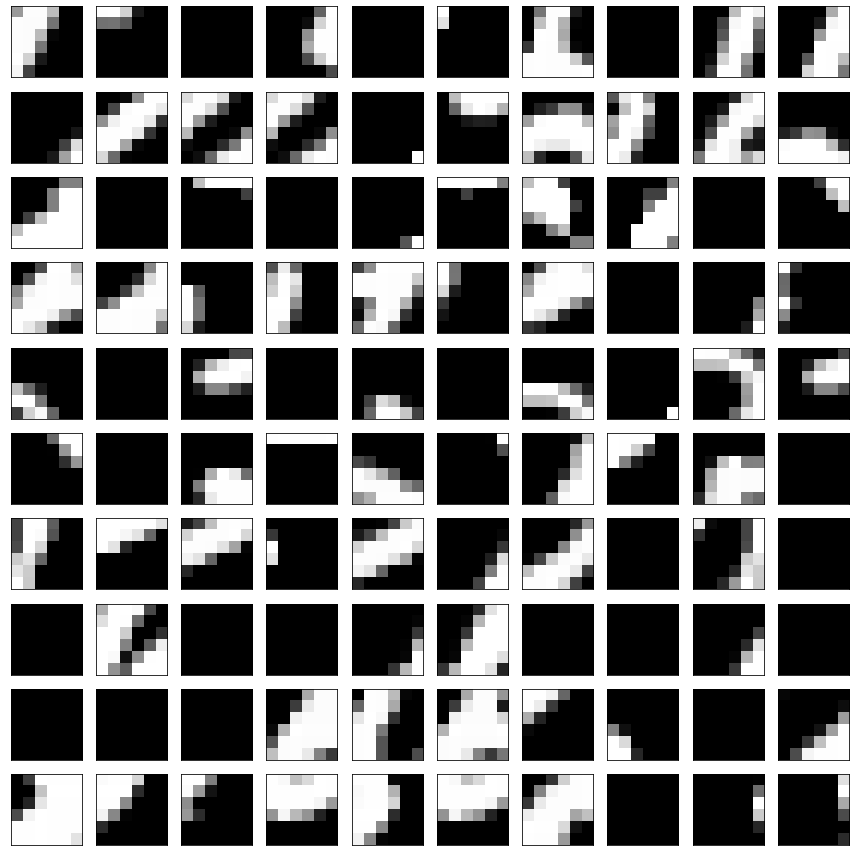

In [318]:
# 随机选取100个patch图显示
patch_num = patch_list.shape[0]
patch_index = random.sample(range(patch_num), 100)
plt.figure(figsize=(12,12))
k = 0
for i in range(1,11):
    for j in range(1,11):
        ax = plt.subplot(10,10,k+1)
        plt.imshow(patch_list[k], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        k += 1
        
plt.tight_layout()

## 1.2 Pre-processing

### 1.2.1 Normalization (Standardization)
#### 采用的是z-score标准化

In [335]:
def Standardization(X):
    u = X.mean()
    s = X.std()
    return (X-u)/(s+1e-6)

In [336]:
time_start = time.time()
patch_ss = patch_list.copy()
for i in range(patch_num):
    patch_ss[i] = Standardization(patch_ss[i])
    
time_end = time.time()
print('Normalization time: {:.1f}s'.format(time_end-time_start))

Normalization time: 2.5s


In [337]:
patch_ss[1000]

array([[-0.41808417,  0.45483882,  0.9326493 ,  0.9326493 ,  0.9326493 ,
         0.78563069],
       [ 0.80400801,  0.94183796,  0.9326493 ,  0.9326493 ,  0.9326493 ,
        -0.30782021],
       [ 0.94183796,  0.95102662,  0.94183796,  0.94183796, -1.21749785,
        -1.39208245],
       [-0.07810364,  0.94183796,  0.84076267, -0.76725336, -1.36451646,
        -1.39208245],
       [ 0.49159347,  0.94183796, -0.15161294, -1.39208245, -1.39208245,
        -1.39208245],
       [ 0.9326493 ,  0.1608016 , -1.22668651, -1.39208245, -1.39208245,
        -1.39208245]])

### 1.2.2 PCA Whitening

In [338]:
def PCA_whitening(X):
    # 减去均值，使得以0为中心
    X -= np.mean(X)
    # 计算协方差矩阵
    cov = np.dot(X.T, X) / X.shape[0]
    # 协方差矩阵奇异值分解SVD
    U,S,V = np.linalg.svd(cov)
    X_rot = np.dot(X, U) 
    X_white = X_rot / np.sqrt(S + 1e-6)
    return X

In [339]:
time_start = time.time()
patch_wh = patch_ss.copy()
for i in range(patch_num):
    patch_wh[i] = PCA_whitening(patch_wh[i])
    
time_end = time.time()
print('PCA-Whitening time: {:.1f}s'.format(time_end-time_start))

PCA-Whitening time: 4.4s


In [340]:
patch_wh[1000]

array([[-0.41808417,  0.45483882,  0.9326493 ,  0.9326493 ,  0.9326493 ,
         0.78563069],
       [ 0.80400801,  0.94183796,  0.9326493 ,  0.9326493 ,  0.9326493 ,
        -0.30782021],
       [ 0.94183796,  0.95102662,  0.94183796,  0.94183796, -1.21749785,
        -1.39208245],
       [-0.07810364,  0.94183796,  0.84076267, -0.76725336, -1.36451646,
        -1.39208245],
       [ 0.49159347,  0.94183796, -0.15161294, -1.39208245, -1.39208245,
        -1.39208245],
       [ 0.9326493 ,  0.1608016 , -1.22668651, -1.39208245, -1.39208245,
        -1.39208245]])

#### ZCA-Whitening

In [1]:
def zca_whitening(inputs):
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #inputs是经过归一化处理的，所以这边就相当于计算协方差矩阵
    U,S,V = np.linalg.svd(sigma) #奇异分解
    epsilon = 0.1                #白化的时候，防止除数为0
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     #计算zca白化矩阵
    return np.dot(ZCAMatrix, inputs)   #白化变换

## 1.3 Unsupervised Learning - K-Means

In [349]:
from sklearn.cluster import KMeans

time_start = time.time()
# 将patch_wh的最后一维展平
patch_wh_flatten = patch_wh.reshape(patch_num, -1)
# K = 1600
kmeans = KMeans(n_clusters=K, random_state=0)
kmeans.fit(patch_wh_flatten)

time_end = time.time()
print('K-Means time: {:.1f}s'.format(time_end-time_start))

K-Means time: 1037.8s


In [356]:
# 无监督学习到的K个中心
C = kmeans.cluster_centers_
C.shape

(1600, 36)

### Visualization
### 可视化学习到的中心(centroids)

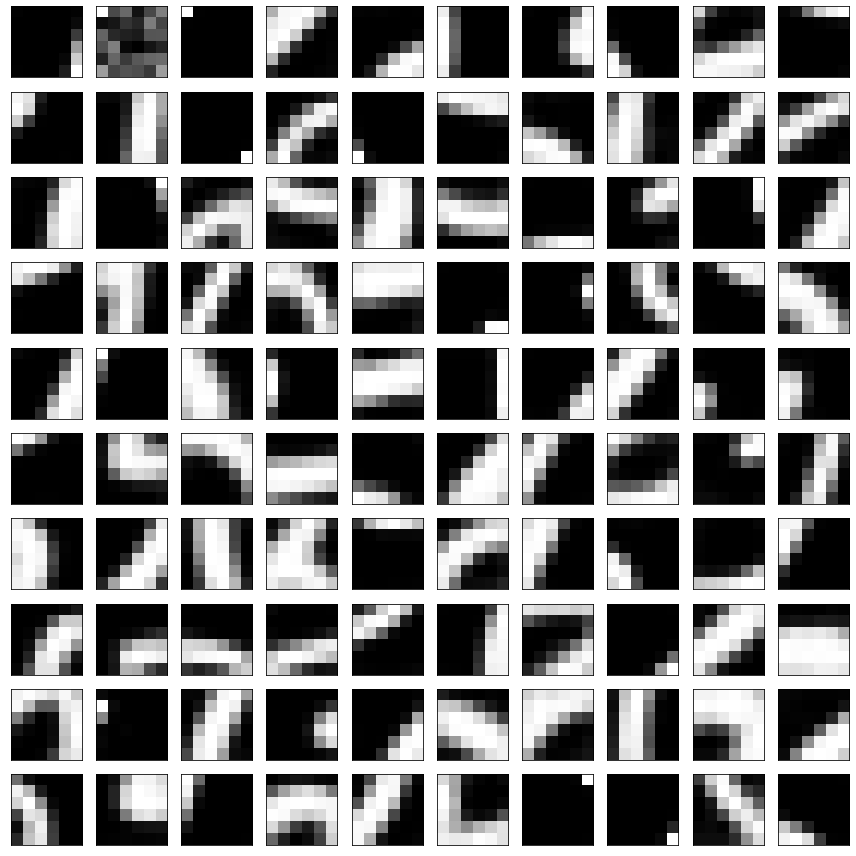

In [367]:
# 随机选取100个中心特征图显示
centroid_index = random.sample(range(K), 100)
plt.figure(figsize=(12,12))
k = 0
for i in range(1,11):
    for j in range(1,11):
        ax = plt.subplot(10,10,k+1)
        img = C[k].reshape(6,6)
        plt.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        k += 1
        
plt.tight_layout()

# 2. Feature Extraction 

## 2.1 Convolutional Extraction


In [368]:
def dist(x, c):
    return np.sum(np.square(x-c))

In [452]:
feature

array([], shape=(10000, 0), dtype=float64)

In [467]:
feature = np.zeros((data_num,4*K))
feature.shape

(10000, 6400)

In [468]:
b = np.zeros((2,2,1600))
b.shape

(2, 2, 1600)

In [471]:
d = b.reshape(4*K)
feature[0] = d

In [475]:
feature[0].shape

(6400,)

In [ ]:
time_start = time.time()

# 扫描后窗口大小
sn = 28-W+1

feature = np.zeros((data_num,4*K))
for i in range(data_num):
    img = data[i].reshape(28,28)
    # 23 * 23 * 1600
    y = np.zeros((sn, sn, K))
    # 感受野滑动
    for sx in range(sn):
        for sy in range(sn):
            patch = img[sx:sx+W, sy:sy+W]
            D = np.zeros(K)
            for k in range(K):
                patch_flatten = patch.reshape(W*W)
                D[k] = dist(patch_flatten, C[k])
            min_c = np.argmin(D)
            # 最接近的中心类下标置1
            y[sx][sy][min_c] = 1
            
    # 4象限池化 23*23 -> 2*2
    for k in range(K):
        f[i][0][0][k] = np.mean(y[:sn//2][:sn//2])
        f[i][0][1][k] = np.mean(y[:sn//2][sn//2:])
        f[i][1][0][k] = np.mean(y[sn//2:][:sn//2])
        f[i][1][1][k] = np.mean(y[sn//2:][sn//2:])
    
    # 最后一维拼接
    feature[i] = f[i].reshape(4*K)
    if i%500 == 0:
        print('Step: ', i)

time_end = time.time()
print('Feature Extraction time: {:.1f}s'.format(time_end-time_start))

In [406]:
feature.shape

(10000, 6400)

# 3. Classification
使用LinearSVM L2作为分类器模型进行训练和预测

### Split Dataset

In [ ]:
feature_train, feature_test, label_train, label_test = train_test_split(feature, label, test_size=1/5, random_state=33)
print('feature_train.shape:', feature_train.shape)
print('feature_test.shape:', feature_test.shape)

### Train

In [341]:
from sklearn.svm import LinearSVC
# svc = SVC()
svc_l2 = LinearSVC(penalty='l2')
svc_l2.fit(feature_train, label_train)

### Test

In [ ]:
label_predict = svc_l2.predict(label_test)

In [ ]:
# Result Evaluation
print('The Accuracy of Naive Bayes:', svc_l2.score(feature_test, label_test))
print(classification_report(label_test, label_predict))